In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def show_image(image):
    plt.gray()
    plt.imshow(image.reshape(28, 28))
    plt.show()
    
# add gaussian noise to imaged
def add_noise(image, image_shape=28*28, mu=0, sigma=0.1):
    mu, sigma = 0, 0.1
    gauss = np.random.normal(mu, sigma, image_shape)
    return image + gauss

In [4]:
# 2 convolutional layers and 1 fully connected layer Encoder
def encoder(x):
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    
    conv1 = tf.contrib.layers.conv2d(x_image, 16, [3,3], stride=2, padding='VALID')
    
    conv2 = tf.contrib.layers.conv2d(conv1, 32, [3,3], stride=2, padding='VALID')
    
    pool2_flat = tf.reshape(conv2, [-1, 6*6*32])
    fc = tf.contrib.layers.fully_connected(pool2_flat, 100)
    
    return fc

# 1 fully connected layer, 2 deconvolutional layers and 1 fc layer Decoder
def decoder(x):
    fc = tf.contrib.layers.fully_connected(x, 6*6*32)
    fc_layer = tf.reshape(fc, [-1, 6, 6, 32])
    
    deconv1 = tf.contrib.layers.conv2d_transpose(fc_layer, 16, [3,3], stride=2, padding='VALID')
    deconv2 = tf.contrib.layers.conv2d_transpose(deconv1, 1, [3,3], stride=2, padding='VALID')
    deconv2_flat = tf.reshape(deconv2, [-1, 27*27])
    fc = tf.contrib.layers.fully_connected(deconv2_flat, 28*28)
    return fc

In [5]:
with tf.device('/device:GPU:0'):
    # noisy image
    x = tf.placeholder(tf.float32, shape=[None, 784], name='x')
    # original image (before adding noise)
    y = tf.placeholder(tf.float32, shape=[None, 784], name='y')
    
# reconstruct images
pred = decoder(encoder(x))
# MSE cost function
#compute difference between reconstructed images and original images
cost = tf.reduce_mean(tf.squared_difference(y, pred))
optimizer = tf.train.AdamOptimizer(1e-4).minimize(cost)

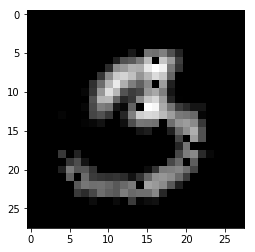

3000 iterations -- train cost: 0.026429    test cost: 0.027519


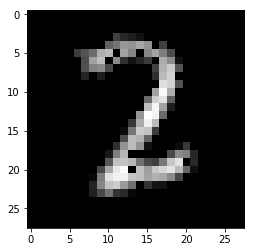

6000 iterations -- train cost: 0.022084    test cost: 0.014957


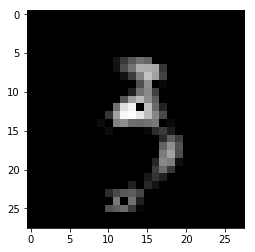

9000 iterations -- train cost: 0.017020    test cost: 0.009993


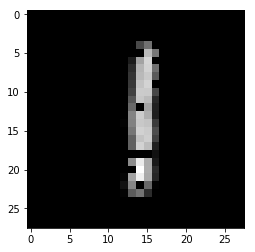

12000 iterations -- train cost: 0.016458    test cost: 0.009176


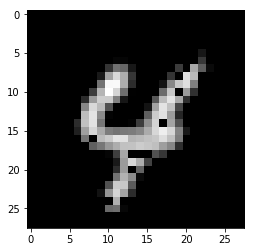

15000 iterations -- train cost: 0.016930    test cost: 0.017433


In [6]:
n_iter = 15000
batch_size = 16
print_every = 3000

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
    
for i in range(n_iter):
    batch_x, _ = mnist.train.next_batch(batch_size)
    _, batch_cost = sess.run([optimizer, cost], feed_dict = {x:add_noise(batch_x), y:batch_x})
    
    # show reconstructed images after every 'print_every' iterations of training
    if (i+1) % print_every == 0:
        batch_x, _ = mnist.test.next_batch(1)
        noise_image = add_noise(batch_x)
        gen_image, test_cost = sess.run([pred,cost], feed_dict = {x:noise_image, y:batch_x})
        show_image(gen_image)
        print('%d iterations -- train cost: %f    test cost: %f' % (i+1, batch_cost, test_cost))

Noisy image


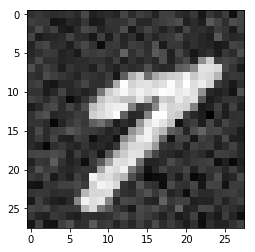

Reconstruct image


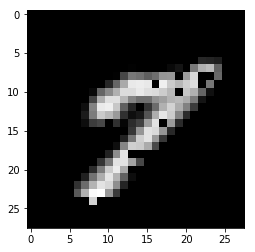

In [7]:
# Testing -- reconstruct images from test set
batch_x, _ = mnist.test.next_batch(1)
noise_image = add_noise(batch_x)
gen_image, test_cost = sess.run([pred,cost], feed_dict = {x:noise_image, y:batch_x})
print('Noisy image')
show_image(noise_image)
print('Reconstruct image')
show_image(gen_image)

Noisy image


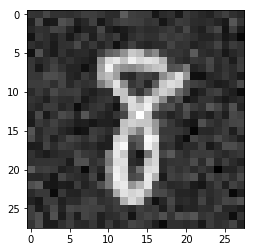

Reconstruct image


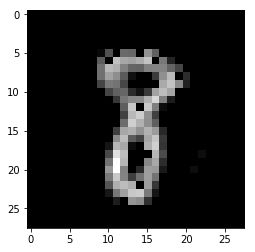

In [9]:
# Testing -- reconstruct images from test set
batch_x, _ = mnist.test.next_batch(1)
noise_image = add_noise(batch_x)
gen_image, test_cost = sess.run([pred,cost], feed_dict = {x:noise_image, y:batch_x})
print('Noisy image')
show_image(noise_image)
print('Reconstruct image')
show_image(gen_image)